In [1]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('LancasterStemmer')
nltk.download('WordNetLemmetizer')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk import LancasterStemmer
from nltk import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer
import math
import re
import unicodedata
import torch
import torchtext
import sklearn
from sklearn.feature_extraction.text import CountVectorizer,  TfidfVectorizer, HashingVectorizer
import csv
import pandas as pd
from sklearn.model_selection import ShuffleSplit
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBModel, XGBRegressor
from sklearn.svm import LinearSVC
import operator
from collections import Counter

from sklearn.preprocessing import LabelEncoder

import seaborn as sns


import warnings
warnings.filterwarnings('ignore')

import re

from bs4 import BeautifulSoup

from html.parser import HTMLParser

import matplotlib.pyplot as plt

import numpy as np

import time

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ardian\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ardian\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Error loading LancasterStemmer: Package 'LancasterStemmer'
[nltk_data]     not found in index
[nltk_data] Error loading WordNetLemmetizer: Package
[nltk_data]     'WordNetLemmetizer' not found in index
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Ardian\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Ardian\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
start_time = time.time()

# Importing files

In [3]:
sentiment_df = pd.read_csv('sentiment_analysis.csv', low_memory = False)

In [4]:
elections_df = pd.read_csv('Canadian_elections_2021.csv', low_memory = False)

In [5]:
sentiment_df.head() #label 1 = positive, label 0 = negative

,ID,text,label
0,7.680980e+17,Josh Jenkins is looking forward to TAB Breeder...,1
1,7.680980e+17,RT @MianUsmanJaved: Congratulations Pakistan o...,1
2,7.680980e+17,"RT @PEPalerts: This September, @YESmag is taki...",1
3,7.680980e+17,"RT @david_gaibis: Newly painted walls, thanks ...",1
4,7.680980e+17,RT @CedricFeschotte: Excited to announce: as o...,1


In [6]:
#Need to remove the extra quotation mark for the string

In [7]:
sentiment_df['text'].iloc[0]

'Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0'

In [8]:
sentiment_df['text'].iloc[0][0]

'J'

In [9]:
sentiment_df['text'].iloc[0][-1]

'0'

In [10]:
sentiment_df['text'].iloc[0][1:]

'osh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks0'

In [11]:
sentiment_df['text'].iloc[0][:-1]

'Josh Jenkins is looking forward to TAB Breeders Crown Super Sunday https://t.co/antImqAo4Y https://t.co/ejnA78Sks'

In [12]:
sentiment_df.label.value_counts()

1    371341
0    179050
Name: label, dtype: int64

In [13]:
sentiment_df.shape

(550391, 3)

In [14]:
elections_df.head()

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,negative,calling election early
1,I do hope Trudeau loses the Canadian election ...,negative,covid
2,"Dear Canadians, This election is a test of how...",positive,NaN
3,Canadian friends: Never forget that Trudeau ha...,negative,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,positive,NaN


In [15]:
elections_df.sentiment.value_counts()

positive    615
negative    387
Name: sentiment, dtype: int64

In [16]:
elections_df.negative_reason.value_counts()

others                                 149
calling election early                  73
tell lies                               61
covid                                   25
economy                                 20
gun control                             16
climate problem                         15
scandal                                 14
healthcare and marijuana                 7
women reproductive right and racism      4
segregation                              3
Name: negative_reason, dtype: int64

In [17]:
elections_df.shape

(1002, 3)

# Data Preparation

In [18]:
# For elections_df, replacing all  'positive' and 'negative' labels with 1 and 0, respectively 

elections_df['sentiment'] = elections_df.apply(lambda row: 1 if row['sentiment'] == 'positive' else 0, axis = 1)

In [19]:
elections_df.head()

,text,sentiment,negative_reason
0,The Canadian election is a power grab by PM Tr...,0,calling election early
1,I do hope Trudeau loses the Canadian election ...,0,covid
2,"Dear Canadians, This election is a test of how...",1,NaN
3,Canadian friends: Never forget that Trudeau ha...,0,calling election early
4,Sorry @theJagmeetSingh I have voted #NDP all m...,1,NaN


In [20]:
elections_df['text']

0       The Canadian election is a power grab by PM Tr...
1       I do hope Trudeau loses the Canadian election ...
2       Dear Canadians, This election is a test of how...
3       Canadian friends: Never forget that Trudeau ha...
4       Sorry @theJagmeetSingh I have voted #NDP all m...
                              ...                        
997     This is absolutely horrible in Canada. The for...
998     @davidakin Trudeau imposes gun control policie...
999     In Canada 🇨🇦 our election is being stolen by t...
1000    O'Toole amends platform on gun control, but qu...
1001    @JustinTrudeau STOP YOUR LIES, STOP YOUR MANIP...
Name: text, Length: 1002, dtype: object

In [21]:
#removing HTML Tags attributes uting BeautifulSoup and re
elections_df['text'] = elections_df.apply(lambda row: BeautifulSoup(row['text']).get_text(), axis = 1)
sentiment_df['text'] = sentiment_df.apply(lambda row: BeautifulSoup(row['text']).get_text(), axis = 1)

elections_df['text'] = elections_df.apply(lambda row: re.sub('<[^<]+?>', '',row['text']), axis = 1)
sentiment_df['text'] = sentiment_df.apply(lambda row: re.sub('<[^<]+?>', '',row['text']), axis = 1)

In [22]:
#Replacing HTML Character codes with ASCII equivalent
elections_df['text'] = elections_df.apply(lambda row: ascii(row['text']), axis = 1)
sentiment_df['text'] = sentiment_df.apply(lambda row: ascii(row['text']), axis = 1)

In [23]:
#Ensuring all texts are in lower case
elections_df['text'] = elections_df.apply(lambda row: row['text'].lower(), axis = 1)
sentiment_df['text'] = sentiment_df.apply(lambda row: row['text'].lower(), axis = 1)

In [24]:
elections_df['text']

0       'the canadian election is a power grab by pm t...
1       'i do hope trudeau loses the canadian election...
2       'dear canadians, this election is a test of ho...
3       'canadian friends: never forget that trudeau h...
4       'sorry @thejagmeetsingh i have voted #ndp all ...
                              ...                        
997     'this is absolutely horrible in canada. the fo...
998     '@davidakin trudeau imposes gun control polici...
999     'in canada \u0001f1e8\u0001f1e6 our election i...
1000    "o'toole amends platform on gun control, but q...
1001    '@justintrudeau stop your lies, stop your mani...
Name: text, Length: 1002, dtype: object

In [25]:
#there are excess ' marks that need to be removed 

In [26]:
#Removing URLs
elections_df['text'] = elections_df.apply(lambda row: re.sub(r'^https?:\/\/.*[\r\n]*', '',row['text'], ), axis = 1)
sentiment_df['text'] = sentiment_df.apply(lambda row: re.sub(r'^https?:\/\/.*[\r\n]*', '',row['text'], ), axis = 1)

In [27]:
url_list = ['https://', 'www.', '.org', '.com', '.net', '/', '|', '.ca']
for substring in url_list:
    elections_df['text'] = elections_df['text'].apply(lambda row: row.replace(substring, ''))
    sentiment_df['text'] = sentiment_df['text'].apply(lambda row: row.replace(substring, ''))

In [28]:
elections_df['text']

0       'the canadian election is a power grab by pm t...
1       'i do hope trudeau loses the canadian election...
2       'dear canadians, this election is a test of ho...
3       'canadian friends: never forget that trudeau h...
4       'sorry @thejagmeetsingh i have voted #ndp all ...
                              ...                        
997     'this is absolutely horrible in canada. the fo...
998     '@davidakin trudeau imposes gun control polici...
999     'in canada \u0001f1e8\u0001f1e6 our election i...
1000    "o'toole amends platform on gun control, but q...
1001    '@justintrudeau stop your lies, stop your mani...
Name: text, Length: 1002, dtype: object

In [29]:
elections_df['text'] = elections_df['text'].apply(lambda row: row.replace('-', ' '))
sentiment_df['text'] = sentiment_df['text'].apply(lambda row: row.replace('-', ' '))

In [30]:
#Removing the first quotation marks ' since there are already double quote "
elections_df['text'] = elections_df.apply(lambda row: row['text'][1:], axis = 1)
sentiment_df['text'] = sentiment_df.apply(lambda row: row['text'][:-1], axis = 1)

In [31]:
#Removing stopwords
stop_words = set(nltk.corpus.stopwords.words('english'))

In [32]:
elections_df['text']

0       the canadian election is a power grab by pm tr...
1       i do hope trudeau loses the canadian election ...
2       dear canadians, this election is a test of how...
3       canadian friends: never forget that trudeau ha...
4       sorry @thejagmeetsingh i have voted #ndp all m...
                              ...                        
997     this is absolutely horrible in canada. the for...
998     @davidakin trudeau imposes gun control policie...
999     in canada \u0001f1e8\u0001f1e6 our election is...
1000    o'toole amends platform on gun control, but qu...
1001    @justintrudeau stop your lies, stop your manip...
Name: text, Length: 1002, dtype: object

In [33]:
elections_df['text'] = elections_df['text'].apply(lambda row: ' '.join([word for word in row.split() if word not in (stop_words)]))
sentiment_df['text'] = sentiment_df['text'].apply(lambda row: ' '.join([word for word in row.split() if word not in (stop_words)]))

In [34]:
elections_df['text']

0       canadian election power grab pm trudeau, yes t...
1       hope trudeau loses canadian election tomorrow ...
2       dear canadians, election test progressive are....
3       canadian friends: never forget trudeau 2 years...
4       sorry @thejagmeetsingh voted #ndp life electio...
                              ...                        
997     absolutely horrible canada. forthcoming electi...
998     @davidakin trudeau imposes gun control policie...
999     canada \u0001f1e8\u0001f1e6 election stolen th...
1000    o'toole amends platform gun control, questions...
1001    @justintrudeau stop lies, stop manipulation, s...
Name: text, Length: 1002, dtype: object

In [35]:
elections_df['text'].iloc[0]

"canadian election power grab pm trudeau, yes take away opposition leaders chosen obstruction (20 non confidence motions) disinformation middle worldwide pandemic. yes, one wanted vote; opposition antics forced it.'"

In [36]:
#lemmatizastion to simplify the words when possible
lemm = WordNetLemmatizer()

In [37]:
elections_df['text'] = elections_df['text'].apply(lambda row: ' '.join([lemm.lemmatize(word) for word in row.split()]))
sentiment_df['text'] = sentiment_df['text'].apply(lambda row: ' '.join([lemm.lemmatize(word) for word in row.split()]))

In [38]:
elections_df['text'].iloc[0]

"canadian election power grab pm trudeau, yes take away opposition leader chosen obstruction (20 non confidence motions) disinformation middle worldwide pandemic. yes, one wanted vote; opposition antic forced it.'"

In [39]:
elections_df['text'].iloc[1]

"hope trudeau loses canadian election tomorrow , called snap one thinking he\\u2019d romp it.. seems people don\\u2019t like black face hypocrite, super wokist & covid restriction groupie.. let\\u2019s hope poll right, might make government think again.'"

In [40]:
sia = SentimentIntensityAnalyzer()

In [41]:
elections_df['NLTK_polarity'] = elections_df['text'].apply(lambda text: sia.polarity_scores(text))
sentiment_df['NLTK_polarity'] = sentiment_df['text'].apply(lambda text: sia.polarity_scores(text))


In [42]:
elections_df.head()

,text,sentiment,negative_reason,NLTK_polarity
0,"canadian election power grab pm trudeau, yes t...",0,calling election early,"{'neg': 0.082, 'neu': 0.681, 'pos': 0.237, 'co..."
1,hope trudeau loses canadian election tomorrow ...,0,covid,"{'neg': 0.099, 'neu': 0.628, 'pos': 0.274, 'co..."
2,"dear canadians, election test progressive are....",1,NaN,"{'neg': 0.188, 'neu': 0.735, 'pos': 0.076, 'co..."
3,canadian friends: never forget trudeau 2 year ...,0,calling election early,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp..."
4,sorry @thejagmeetsingh voted #ndp life electio...,1,NaN,"{'neg': 0.141, 'neu': 0.704, 'pos': 0.156, 'co..."


In [43]:
#dropping column id
sentiment_df.drop(labels = ['ID'], axis = 1, inplace = True)

# Exploratory analysis

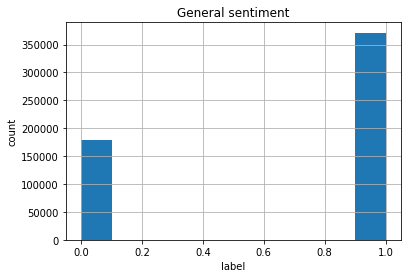

In [44]:
#sentiment in general
sentiment_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("General sentiment")
plt.show()

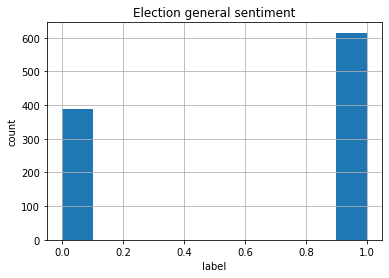

In [45]:
elections_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Election general sentiment")
plt.show()

In [46]:
#Key terms for NDP: Singh, Jagmeet, ndp
ndp_search = ['ndp', 'singh', 'jagmeet']
ndp_sentiment_df = sentiment_df[sentiment_df['text'].str.contains('|'.join(ndp_search))]
ndp_elections_df = elections_df[elections_df['text'].str.contains('|'.join(ndp_search))]

In [47]:
ndp_sentiment_df.label.value_counts()

1    747
0    340
Name: label, dtype: int64

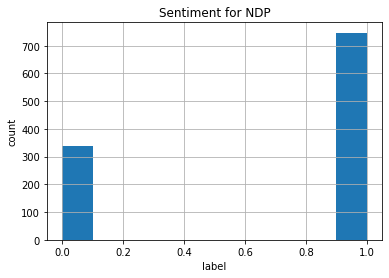

In [48]:
ndp_sentiment_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for NDP")
plt.show()

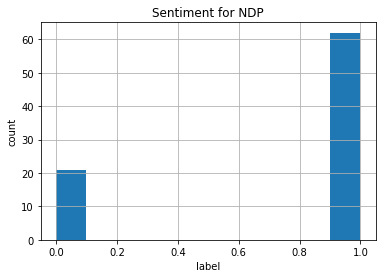

In [49]:
ndp_elections_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for NDP")
plt.show()

In [50]:
#key terms for Conservatives: Toole, conservatives, cons, erin

In [51]:
cons_search = ['toole', 'conservatives', 'cons', 'erin', 'cpc']

cons_sentiment_df = sentiment_df[sentiment_df['text'].str.contains('|'.join(cons_search))]
cons_elections_df = elections_df[elections_df['text'].str.contains('|'.join(cons_search))]

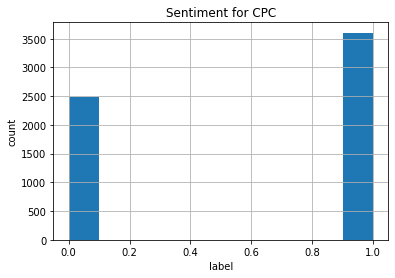

In [52]:
cons_sentiment_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for CPC")
plt.show()

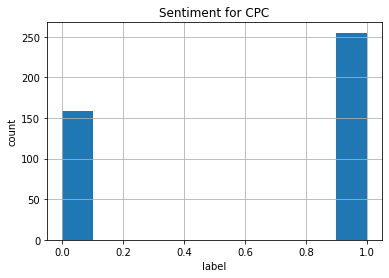

In [53]:
cons_elections_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for CPC")
plt.show()

In [54]:
#key terms for liberals: trudeau, justin, liberal, liberals

In [55]:
liberals_search = ['trudeau', 'justin', 'liberal', 'lpc', 'liberals']

liberals_sentiment_df = sentiment_df[sentiment_df['text'].str.contains('|'.join(liberals_search))]
liberals_elections_df = elections_df[elections_df['text'].str.contains('|'.join(liberals_search))]

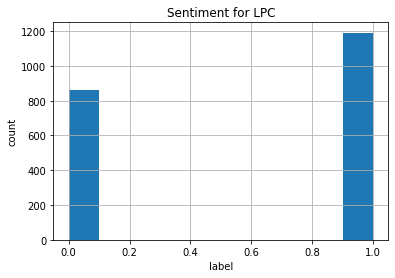

In [56]:
liberals_sentiment_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for LPC")
plt.show()

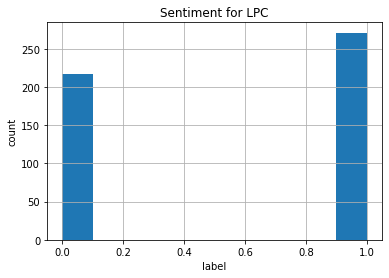

In [57]:
liberals_elections_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for LPC")
plt.show()

In [58]:
#key terms for PPC: ppc, maxime, bernier

In [59]:
ppc_search = ['ppc', 'maxime', 'bernier']

ppc_sentiment_df = sentiment_df[sentiment_df['text'].str.contains('|'.join(ppc_search))]
ppc_elections_df = elections_df[elections_df['text'].str.contains('|'.join(ppc_search))]

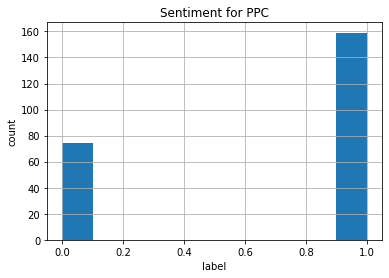

In [60]:
ppc_sentiment_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for PPC")
plt.show()

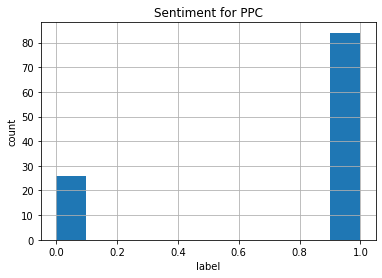

In [61]:
ppc_elections_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for PPC")
plt.show()

In [62]:
#key terms for BQ: bloc, quebecois, yves, blanchet, bq

In [63]:
bloc_search = ['bloc', 'quebecois', 'yves', 'blanchet', 'bq']

bloc_sentiment_df = sentiment_df[sentiment_df['text'].str.contains('|'.join(bloc_search))]
bloc_elections_df = elections_df[elections_df['text'].str.contains('|'.join(bloc_search))]

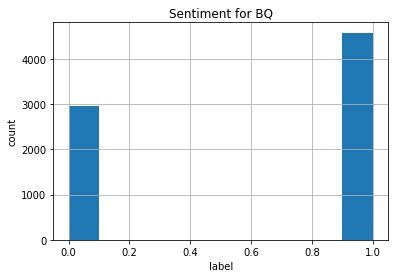

In [64]:
bloc_sentiment_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for BQ")
plt.show()

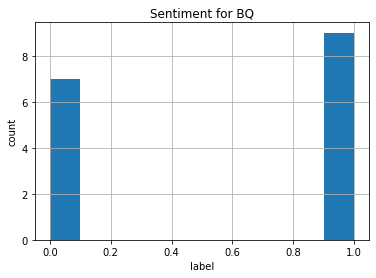

In [65]:
bloc_elections_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for BQ")
plt.show()

In [66]:
#key terms for Green: green, greens, paul, annemarie

In [67]:
green_search = ['green', 'greens', 'paul', 'annemarie']

green_sentiment_df = sentiment_df[sentiment_df['text'].str.contains('|'.join(green_search))]
green_elections_df = elections_df[elections_df['text'].str.contains('|'.join(green_search))]

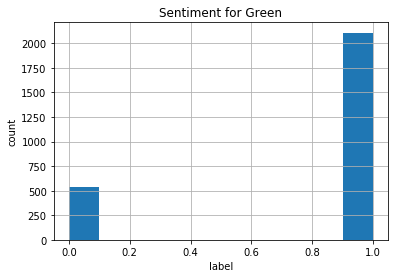

In [68]:
green_sentiment_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for Green")
plt.show()

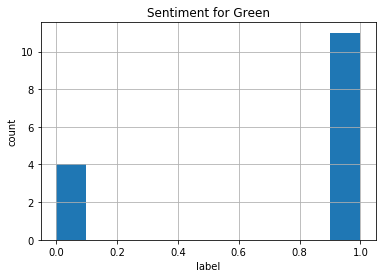

In [69]:
green_elections_df.hist()
plt.gcf()
plt.xlabel("label")
plt.ylabel('count')
plt.title("Sentiment for Green")
plt.show()

## Notes

Overall, I noticed that the sentiment tends to be towards label 1. I would not be surprised if the models would be more biased towards making predictions iwth label 1

# Model preparation

In [70]:
sentiment_df_text = sentiment_df['text'].values
elections_df_text = elections_df['text'].values

In [71]:
tokenizer = RegexpTokenizer(r'\w+|\$[\d\.]+|\S+')

In [72]:
#preparing all the data for the count vectorizer.
#Note that the corpus is combining both sentiment and elections to ensure all words are properly vectorized 

vectorizer = CountVectorizer(tokenizer = tokenizer.tokenize, stop_words = 'english', analyzer = 'word')

In [73]:
corpus = np.concatenate((sentiment_df_text, elections_df_text), axis = None)

In [74]:
vectorizer.fit_transform(corpus)

<551393x1135719 sparse matrix of type '<class 'numpy.int64'>'
	with 6028566 stored elements in Compressed Sparse Row format>

In [75]:
elections_countvec_transform = vectorizer.transform(elections_df['text'])

In [76]:
sentiment_countvec_transform = vectorizer.transform(sentiment_df['text'])

In [77]:
#preparing all the data for the idf vectorizer

In [78]:
idf_vectorizer = TfidfVectorizer(tokenizer = tokenizer.tokenize, stop_words = 'english', analyzer = 'word')

In [79]:
idf_vectorizer.fit_transform(corpus)

<551393x1135719 sparse matrix of type '<class 'numpy.float64'>'
	with 6028566 stored elements in Compressed Sparse Row format>

In [80]:
elections_idf_vect_transform = idf_vectorizer.transform(elections_df['text'])

In [81]:
sentiment_idf_vect_transform = idf_vectorizer.transform(sentiment_df['text'])

# splitting the data 

In [82]:
train_indices = None
test_indices = None

In [83]:
splitter = ShuffleSplit(n_splits = 1, test_size = 0.30, random_state = 42)

In [84]:
for train_index, test_index in splitter.split(sentiment_df):
    train_indices = train_index
    test_indices = test_index
    

In [85]:
train_indices

array([516742, 136087, 106201, ..., 365838, 131932, 121958])

In [86]:
test_indices

array([354901, 312571, 275555, ..., 243831,  48763, 295355])

# Preparing the models for bag-of-words

In [87]:
x_train_countvec = sentiment_countvec_transform[train_indices]
y_train_countvec = sentiment_df['label'].values[train_indices]

x_test_countvec = sentiment_countvec_transform[test_indices]
y_test_countvec = sentiment_df['label'].values[test_indices]

In [88]:
#logistic regression
lr_countvec = LogisticRegression(n_jobs = -1)

lr_countvec.fit(x_train_countvec, y_train_countvec)

lr_countvec_predict = lr_countvec.predict(x_test_countvec)

lr_countvec_f1 = f1_score(y_test_countvec, lr_countvec_predict)
lr_countvec_accuracy = accuracy_score(y_test_countvec, lr_countvec_predict)
lr_countvec_auc = roc_auc_score(y_test_countvec, lr_countvec_predict)

print("Logistic Regression results")
print("Accuracy: " + str(lr_countvec_accuracy))
print("F1 score: " + str(lr_countvec_f1))
print("AUC: " + str(lr_countvec_auc))

Logistic Regression results
Accuracy: 0.9771920687023825
F1 score: 0.9830747658511154
AUC: 0.9747024163696764


In [89]:
#k-NN

knn_countvec = KNeighborsClassifier(n_jobs = -1)

knn_countvec.fit(x_train_countvec, y_train_countvec)

knn_countvec_predict = knn_countvec.predict(x_test_countvec)

knn_countvec_f1 = f1_score(y_test_countvec, knn_countvec_predict)
knn_countvec_accuracy = accuracy_score(y_test_countvec, knn_countvec_predict)
knn_countvec_auc = roc_auc_score(y_test_countvec, knn_countvec_predict)

print("KNN classifier results")
print("Accuracy: " + str(knn_countvec_accuracy))
print("F1 score: " + str(knn_countvec_f1))
print("AUC: " + str(knn_countvec_auc))

KNN classifier results
Accuracy: 0.8900241039741276
F1 score: 0.9169483230961321
AUC: 0.8847249207968557


In [90]:
#Naive Bayes (MultinomialNB)

nb_countvec = MultinomialNB()

nb_countvec.fit(x_train_countvec, y_train_countvec)

nb_countvec_predict = nb_countvec.predict(x_test_countvec)

nb_countvec_f1 = f1_score(y_test_countvec, nb_countvec_predict)
nb_countvec_accuracy = accuracy_score(y_test_countvec, nb_countvec_predict)
nb_countvec_auc = roc_auc_score(y_test_countvec, nb_countvec_predict)
print("Naive Bayes results")
print("Accuracy: " + str(nb_countvec_accuracy))
print("F1 score: " + str(nb_countvec_f1))
print("AUC: " + str(nb_countvec_auc))

Naive Bayes results
Accuracy: 0.9522099347133565
F1 score: 0.9650938012854824
AUC: 0.9376843020186879


In [91]:
#SVM -> outlier detection

svc_countvec = LinearSVC()

svc_countvec.fit(x_train_countvec, y_train_countvec)

svc_countvec_predict = svc_countvec.predict(x_test_countvec)

svc_countvec_f1 = f1_score(y_test_countvec, svc_countvec_predict)
svc_countvec_accuracy = accuracy_score(y_test_countvec, svc_countvec_predict)
svc_countvec_auc = roc_auc_score(y_test_countvec, svc_countvec_predict)

print("SVM Classifier results")
print("Accuracy: " + str(svc_countvec_accuracy))
print("F1 score: " + str(svc_countvec_f1))
print("AUC: " + str(svc_countvec_auc))


SVM Classifier results
Accuracy: 0.9784578301578265
F1 score: 0.9840119741638536
AUC: 0.9762139173181762


In [92]:
#decision trees
tree_countvec = DecisionTreeClassifier()

tree_countvec.fit(x_train_countvec, y_train_countvec)

tree_countvec_predict = tree_countvec.predict(x_test_countvec)

tree_countvec_f1 = f1_score(y_test_countvec, tree_countvec_predict)
tree_countvec_accuracy = accuracy_score(y_test_countvec, tree_countvec_predict)
tree_countvec_auc = roc_auc_score(y_test_countvec, tree_countvec_predict)

print("Decision tree results")
print("Accuracy: " + str(tree_countvec_accuracy))
print("F1 score: " + str(tree_countvec_f1))
print("AUC: " + str(tree_countvec_auc))

Decision tree results
Accuracy: 0.9532455577223561
F1 score: 0.9654295335673856
AUC: 0.9454916240556854


In [93]:
#random forest
rf_countvec = RandomForestClassifier(n_jobs = -1)

rf_countvec.fit(x_train_countvec, y_train_countvec)

rf_countvec_predict = rf_countvec.predict(x_test_countvec)

rf_countvec_f1 = f1_score(y_test_countvec, rf_countvec_predict)
rf_countvec_accuracy = accuracy_score(y_test_countvec, rf_countvec_predict)
rf_countvec_auc = roc_auc_score(y_test_countvec, rf_countvec_predict)

print("Random Forest results")
print("Accuracy: " + str(rf_countvec_accuracy))
print("F1 score: " + str(rf_countvec_f1))
print("AUC: " + str(rf_countvec_auc))

Random Forest results
Accuracy: 0.9407878002398284
F1 score: 0.9558083718659741
AUC: 0.9362924434229916


In [94]:
#XGBoost 
xgb_countvec = XGBRegressor(objective = 'binary:hinge', n_jobs = -1)

xgb_countvec.fit(x_train_countvec, y_train_countvec, eval_set = [(x_test_countvec, y_test_countvec)], verbose = False)

xgb_countvec_predict = xgb_countvec.predict(x_test_countvec)

xgb_countvec_f1 = f1_score(y_test_countvec, xgb_countvec_predict)
xgb_countvec_accuracy = accuracy_score(y_test_countvec, xgb_countvec_predict)
xgb_countvec_auc = roc_auc_score(y_test_countvec, xgb_countvec_predict)

print("XGB results")
print("Accuracy: " + str(xgb_countvec_accuracy))
print("F1 score: " + str(xgb_countvec_f1))
print("AUC: " + str(xgb_countvec_auc))

XGB results
Accuracy: 0.8780750735837402
F1 score: 0.9050556498773816
AUC: 0.8870334400515196


## Notes
Besides accuracy, F1 was chosen on the basis that it takes note of the positive and negative rates. AUC was also chosen to show the different true positive rates and false positive rates with respect to different decision thresholds. Given that LogisticRegression and LinearSVC achieved the best performance on default parameters, LogisticRegression will be chosen in the interest of time because this model was much faster to train than the LinearSVC

# Preparing models for TF-IDF

In [95]:
x_train_idf = sentiment_idf_vect_transform[train_indices]
y_train_idf = sentiment_df['label'].values[train_indices]

x_test_idf = sentiment_idf_vect_transform[test_indices]
y_test_idf = sentiment_df['label'].values[test_indices]

In [96]:
# logistic regression
lr_idf = LogisticRegression(n_jobs = -1)

lr_idf.fit(x_train_idf, y_train_idf)

lr_idf_predict = lr_idf.predict(x_test_idf)

lr_idf_f1 = f1_score(y_test_idf, lr_idf_predict)
lr_idf_accuracy = accuracy_score(y_test_idf, lr_idf_predict)
lr_idf_auc = roc_auc_score(y_test_idf, lr_idf_predict)

print("Logistic Regression results")
print("Accuracy: " + str(lr_idf_accuracy))
print("F1 score: " + str(lr_idf_f1))
print("AUC: " + str(lr_idf_auc))

Logistic Regression results
Accuracy: 0.9711418500708584
F1 score: 0.9786281659692229
AUC: 0.9667298015987483


In [97]:
#KNN

knn_idf = KNeighborsClassifier(n_jobs = -1)

knn_idf.fit(x_train_idf, y_train_idf)

knn_idf_predict = knn_idf.predict(x_test_idf)

knn_idf_f1 = f1_score(y_test_idf, knn_idf_predict)
knn_idf_accuracy = accuracy_score(y_test_idf, knn_idf_predict)
knn_idf_auc = roc_auc_score(y_test_idf, knn_idf_predict)

print("KNN classifier results")
print("Accuracy: " + str(knn_idf_accuracy))
print("F1 score: " + str(knn_idf_f1))
print("AUC: " + str(knn_idf_auc))

KNN classifier results
Accuracy: 0.8622681960779564
F1 score: 0.898767872086605
AUC: 0.8386450050643844


In [98]:
# Naive Bayes
nb_idf = MultinomialNB()

nb_idf.fit(x_train_idf, y_train_idf)

nb_idf_predict = nb_idf.predict(x_test_idf)

nb_idf_f1 = f1_score(y_test_idf, nb_idf_predict)
nb_idf_accuracy = accuracy_score(y_test_idf, nb_idf_predict)
nb_idf_auc = roc_auc_score(y_test_idf, nb_idf_predict)

print("Naive Bayes results")
print("Accuracy: " + str(nb_idf_accuracy))
print("F1 score: " + str(nb_idf_f1))
print("AUC: " + str(nb_idf_auc))

Naive Bayes results
Accuracy: 0.8729696338376192
F1 score: 0.9136586108812789
AUC: 0.8067949613148807


In [99]:
#SVM. Linear SVC chosen due to classifier and Linear SVC recommended for larger number of samples 

svc_idf = LinearSVC()

svc_idf.fit(x_train_idf, y_train_idf)

svc_idf_predict = svc_idf.predict(x_test_idf)

svc_idf_f1 = f1_score(y_test_idf, svc_idf_predict)
svc_idf_accuracy = accuracy_score(y_test_idf, svc_idf_predict)
svc_idf_auc = roc_auc_score(y_test_idf, svc_idf_predict)

print("SVM Classifier results")
print("Accuracy: " + str(svc_idf_accuracy))
print("F1 score: " + str(svc_idf_f1))
print("AUC: " + str(svc_idf_auc))

SVM Classifier results
Accuracy: 0.9785547305563295
F1 score: 0.9840977576985085
AUC: 0.9758568900926983


In [100]:
#decision trees
tree_idf = DecisionTreeClassifier()

tree_idf.fit(x_train_idf, y_train_idf)

tree_idf_predict = tree_idf.predict(x_test_idf)

tree_idf_f1 = f1_score(y_test_idf, tree_idf_predict)
tree_idf_accuracy = accuracy_score(y_test_idf, tree_idf_predict)
tree_idf_auc = roc_auc_score(y_test_idf, tree_idf_predict)

print("Decision tree results")
print("Accuracy: " + str(tree_idf_accuracy))
print("F1 score: " + str(tree_idf_f1))
print("AUC: " + str(tree_idf_auc))

Decision tree results
Accuracy: 0.944663816179944
F1 score: 0.9590267220929242
AUC: 0.9364715796468838


In [101]:
#random forest
rf_idf = RandomForestClassifier(n_jobs = -1)

rf_idf.fit(x_train_idf, y_train_idf)

rf_idf_predict = rf_idf.predict(x_test_idf)

rf_idf_f1 = f1_score(y_test_idf, rf_idf_predict)
rf_idf_accuracy = accuracy_score(y_test_idf, rf_idf_predict)
rf_idf_auc = roc_auc_score(y_test_idf, rf_idf_predict)

print("Random Forest results")
print("Accuracy: " + str(rf_idf_accuracy))
print("F1 score: " + str(rf_idf_f1))
print("AUC: " + str(rf_idf_auc))

Random Forest results
Accuracy: 0.9384803595004785
F1 score: 0.954443527554535
AUC: 0.9294843726843853


In [102]:
#XGBoost 
xgb_idf = XGBRegressor(objective = 'binary:hinge', n_jobs = -1)

xgb_idf.fit(x_train_idf, y_train_idf, eval_set = [(x_test_idf, y_test_idf)], verbose = False)

xgb_idf_predict = xgb_idf.predict(x_test_idf)

xgb_idf_f1 = f1_score(y_test_idf, xgb_idf_predict)
xgb_idf_accuracy = accuracy_score(y_test_idf, xgb_idf_predict)
xgb_idf_auc = roc_auc_score(y_test_idf, xgb_idf_predict)

print("XGB results")
print("Accuracy: " + str(xgb_idf_accuracy))
print("F1 score: " + str(xgb_idf_f1))
print("AUC: " + str(xgb_idf_auc))

XGB results
Accuracy: 0.8731270969851863
F1 score: 0.9010387880333885
AUC: 0.8822436063104455


# Choosing best model to visualize sentiment prediction and true labels between parties

In [103]:
#choose logistic regression due to generally highest AUC and highest F1 score and faster training time than LinearSVC



<Figure size 432x288 with 0 Axes>

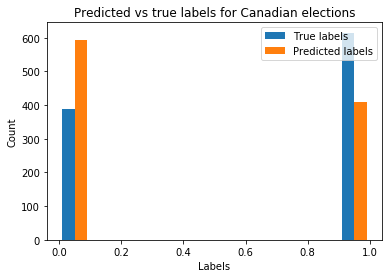

In [104]:
chosen_model_predict = lr_countvec.predict(elections_countvec_transform)

plt.figure()
bins = [0, 1]

plt.figure()
plt.hist([elections_df['sentiment'].values, chosen_model_predict], label = ['True labels', 'Predicted labels'], align = 'mid')

plt.xlabel("Labels")
plt.ylabel("Count")
plt.legend(loc = 'upper right')
plt.title('Predicted vs true labels for Canadian elections')
plt.show()

In [105]:
elections_f1_score = f1_score(elections_df['sentiment'].values, chosen_model_predict)
elections_accuracy = accuracy_score(elections_df['sentiment'].values, chosen_model_predict)
elections_auc = roc_auc_score(elections_df['sentiment'].values, chosen_model_predict)

print("F1 score: " + str(elections_f1_score))
print("AUC: " + str(elections_auc))
print("Accuracy: " + str(elections_accuracy))

F1 score: 0.708984375
AUC: 0.7356904266717086
Accuracy: 0.7025948103792415


<Figure size 432x288 with 0 Axes>

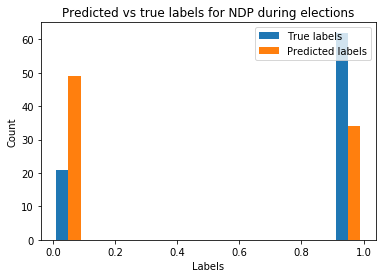

In [106]:
#Predicted vs actual sentiment for NDP
ndp_elections_predict = chosen_model_predict[ndp_elections_df.index.tolist()]

plt.figure()
bins = [0, 1]

plt.figure()
plt.hist([ndp_elections_df['sentiment'].values, ndp_elections_predict], label = ['True labels', 'Predicted labels'], align = 'mid')

plt.xlabel("Labels")
plt.ylabel("Count")
plt.legend(loc = 'upper right')
plt.title('Predicted vs true labels for NDP during elections')
plt.show()

<Figure size 432x288 with 0 Axes>

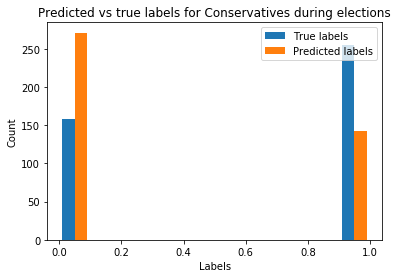

In [107]:
#Predicted vs actual sentiment for Conservatives

cons_elections_predict = chosen_model_predict[cons_elections_df.index.tolist()]

plt.figure()
bins = [0, 1]

plt.figure()
plt.hist([cons_elections_df['sentiment'].values, cons_elections_predict], label = ['True labels', 'Predicted labels'], align = 'mid')

plt.xlabel("Labels")
plt.ylabel("Count")
plt.legend(loc = 'upper right')
plt.title('Predicted vs true labels for Conservatives during elections')
plt.show()

<Figure size 432x288 with 0 Axes>

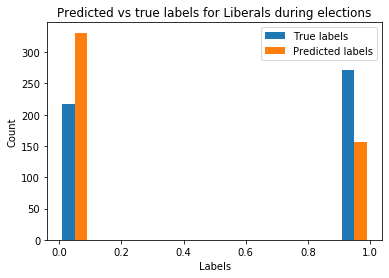

In [108]:
#Predicted vs actual sentiment for Liberals 

liberals_elections_predict = chosen_model_predict[liberals_elections_df.index.tolist()]

plt.figure()
bins = [0, 1]

plt.figure()
plt.hist([liberals_elections_df['sentiment'].values, liberals_elections_predict], label = ['True labels', 'Predicted labels'], align = 'mid')

plt.xlabel("Labels")
plt.ylabel("Count")
plt.legend(loc = 'upper right')
plt.title('Predicted vs true labels for Liberals during elections')
plt.show()

<Figure size 432x288 with 0 Axes>

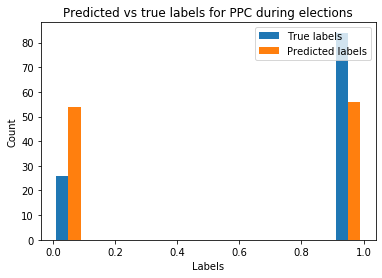

In [109]:
#Predicted vs actual sentiment for PPC 

ppc_elections_predict = chosen_model_predict[ppc_elections_df.index.tolist()]

plt.figure()
bins = [0, 1]

plt.figure()
plt.hist([ppc_elections_df['sentiment'].values, ppc_elections_predict], label = ['True labels', 'Predicted labels'], align = 'mid')

plt.xlabel("Labels")
plt.ylabel("Count")
plt.legend(loc = 'upper right')
plt.title('Predicted vs true labels for PPC during elections')
plt.show()

##  Discussion of findings
This could be very much because the training set is more general sentiment related while the election is more specific (and also less tweets).
It could  be that the models are more ready for the kind of data used in sentiment and less prepared for election. 
Sarcasm could perhaps be a reason why the elections df is so different compared to the sentiment df. 
It could also be that because the general sentiment covers all sorts of topics, it could be that anything political in the general sentiment is more likely to be negative.
Therefore, when applied from training general sentiment to elections, the model may have learned to be more likely to assume politics as negative topics. 

# Split negative election tweets to predict reason of negative tweets

In [111]:
negative_elections_df = elections_df.loc[elections_df['sentiment'] == 0]

In [112]:
negative_elections_df.head()

,text,sentiment,negative_reason,NLTK_polarity
0,"canadian election power grab pm trudeau, yes t...",0,calling election early,"{'neg': 0.082, 'neu': 0.681, 'pos': 0.237, 'co..."
1,hope trudeau loses canadian election tomorrow ...,0,covid,"{'neg': 0.099, 'neu': 0.628, 'pos': 0.274, 'co..."
3,canadian friends: never forget trudeau 2 year ...,0,calling election early,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp..."
5,vaccine & gun key election o'toole serious pla...,0,covid,"{'neg': 0.173, 'neu': 0.652, 'pos': 0.176, 'co..."
6,"i\u2019m sorry, moderator respond leadership c...",0,others,"{'neg': 0.201, 'neu': 0.716, 'pos': 0.083, 'co..."


In [113]:
negative_elections_indexes = negative_elections_df.index.tolist()

In [114]:
negative_elections_countvec = elections_countvec_transform[negative_elections_indexes]

In [115]:
negative_elections_df = negative_elections_df.reset_index(drop = True, inplace = False)

In [116]:
negative_elections_df.head()

,text,sentiment,negative_reason,NLTK_polarity
0,"canadian election power grab pm trudeau, yes t...",0,calling election early,"{'neg': 0.082, 'neu': 0.681, 'pos': 0.237, 'co..."
1,hope trudeau loses canadian election tomorrow ...,0,covid,"{'neg': 0.099, 'neu': 0.628, 'pos': 0.274, 'co..."
2,canadian friends: never forget trudeau 2 year ...,0,calling election early,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp..."
3,vaccine & gun key election o'toole serious pla...,0,covid,"{'neg': 0.173, 'neu': 0.652, 'pos': 0.176, 'co..."
4,"i\u2019m sorry, moderator respond leadership c...",0,others,"{'neg': 0.201, 'neu': 0.716, 'pos': 0.083, 'co..."


In [117]:
negative_elections_df['negative_reason'].unique()

array(['calling election early', 'covid ', 'others', 'scandal',
       'tell lies', 'gun control', 'economy', 'healthcare and marijuana',
       'segregation', 'women reproductive right and racism',
       'climate problem'], dtype=object)

In [118]:
negative_elections_df['negative_reason'].value_counts()

others                                 149
calling election early                  73
tell lies                               61
covid                                   25
economy                                 20
gun control                             16
climate problem                         15
scandal                                 14
healthcare and marijuana                 7
women reproductive right and racism      4
segregation                              3
Name: negative_reason, dtype: int64

In [119]:
negative_elections_df['negative_reason'] = LabelEncoder().fit_transform(negative_elections_df['negative_reason'])

In [120]:
negative_elections_df.head()

,text,sentiment,negative_reason,NLTK_polarity
0,"canadian election power grab pm trudeau, yes t...",0,0,"{'neg': 0.082, 'neu': 0.681, 'pos': 0.237, 'co..."
1,hope trudeau loses canadian election tomorrow ...,0,2,"{'neg': 0.099, 'neu': 0.628, 'pos': 0.274, 'co..."
2,canadian friends: never forget trudeau 2 year ...,0,0,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp..."
3,vaccine & gun key election o'toole serious pla...,0,2,"{'neg': 0.173, 'neu': 0.652, 'pos': 0.176, 'co..."
4,"i\u2019m sorry, moderator respond leadership c...",0,6,"{'neg': 0.201, 'neu': 0.716, 'pos': 0.083, 'co..."


In [121]:
negative_train_indices = None
negative_test_indices = None

In [122]:
for train_index, test_index in splitter.split(negative_elections_df):
    negative_train_indices = train_index
    negative_test_indices = test_index

In [123]:
negative_x_train_countvec = negative_elections_countvec[negative_train_indices]
negative_y_train_countvec = negative_elections_df['negative_reason'].values[negative_train_indices]

negative_x_test_countvec = negative_elections_countvec[negative_test_indices]
negative_y_test_countvec = negative_elections_df['negative_reason'].values[negative_test_indices]

In [124]:
negative_model = LogisticRegression(n_jobs = -1)

negative_model.fit(negative_x_train_countvec, negative_y_train_countvec)

negative_model_predict = negative_model.predict(negative_x_test_countvec)

negative_model_f1 = f1_score(negative_y_test_countvec, negative_model_predict, average = 'micro')
negative_model_accuracy = accuracy_score(negative_y_test_countvec, negative_model_predict)

print("Negative reason F1 score: " + str(negative_model_f1))
print("Negative reason accuracy: " + str(negative_model_accuracy))

Negative reason F1 score: 0.4444444444444444
Negative reason accuracy: 0.4444444444444444


## Discussion
The model may fail to predict the correct reason because of the severe imbalance of all the other labels. 
For example, "other" is disproportionately higher, so the model can be expected to be more biased towards "others".
One way to improve model accuracy is to ensure that the data is more balanced.

# Frequency of words for positive and negative tweets in elections.csv

In [127]:
#Top 50 words for positive labels

In [128]:
positive_elections_df = elections_df.loc[elections_df['sentiment'] == 1]

In [129]:
positive_corpus = positive_elections_df['text'].values

In [130]:
positive_vectorizer = CountVectorizer(tokenizer = tokenizer.tokenize, stop_words = 'english', analyzer = 'word')
positive_vectorizer.fit_transform(positive_corpus)

<615x3267 sparse matrix of type '<class 'numpy.int64'>'
	with 10353 stored elements in Compressed Sparse Row format>

In [131]:
positive_counter = Counter(positive_vectorizer.vocabulary_)

In [132]:
for k, v in positive_counter.most_common(50):
    print (k, v)

zero 3266
youtube 3265
youth 3264
young 3263
yo 3262
yesterday 3261
yes 3260
yelling 3259
years 3258
year 3257
yeah 3256
yea 3255
ya 3254
y 3253
xi 3252
wtg 3251
wrote 3250
wrong 3249
wow 3248
wouldn 3247
worthwhile 3246
worth 3245
worry 3244
world 3243
working 3242
workers 3241
worker 3240
worked 3239
work 3238
word 3237
woohoo 3236
wondering 3235
wonderful 3234
wonder 3233
won 3232
women 3231
woman 3230
witty 3229
wishing 3228
wish 3227
wisely 3226
wise 3225
wisdom 3224
wipe 3223
wins 3222
winning 3221
winnie 3220
wing 3219
win 3218
willingness 3217


In [133]:
#Top 50 words for negative labels

In [134]:
negative_elections_df = elections_df.loc[elections_df['sentiment'] == 0]

In [135]:
negative_corpus = negative_elections_df['text'].values

In [136]:
negative_vectorizer = CountVectorizer(tokenizer = tokenizer.tokenize, stop_words = 'english', analyzer = 'word')
negative_vectorizer.fit_transform(negative_corpus)

<387x2668 sparse matrix of type '<class 'numpy.int64'>'
	with 7198 stored elements in Compressed Sparse Row format>

In [137]:
negative_counter = Counter(negative_vectorizer.vocabulary_)

In [138]:
for k, v in negative_counter.most_common(50):
    print(k, v)

zero 2667
zealot 2666
yup 2665
younger 2664
yo 2663
yesterday 2662
yes 2661
yelled 2660
years 2659
year 2658
yeah 2657
yankee 2656
y 2655
wth 2654
wtf 2653
wrongdoing 2652
wrong 2651
write 2650
wrecking 2649
wow 2648
wouldn 2647
worthless 2646
worth 2645
worst 2644
worse 2643
worrying 2642
worry 2641
worried 2640
worn 2639
worldwide 2638
worldview 2637
world 2636
works 2635
working 2634
workers 2633
worker 2632
work 2631
wore 2630
wordsmithing 2629
word 2628
wood 2627
wont 2626
won 2625
women 2624
woman 2623
wokist 2622
witness 2621
withholding 2620
wishing 2619
wish 2618


## Notes
Between both positive and negative sentamints, it appears there are several similarities such as with regards to the youth, workers, the world, and women. However, there are some differences such as how the positive tweets focus more on winning, worthwhile, and wisdom, while the negative tweets focus more on worthless, wokist, and slang terms such as “wtf”. 

In [139]:
end_time = time.time()

print("Total elapsed time (seconds): " + str(end_time-start_time))

Total elapsed time (seconds): 8437.708517551422
